In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.8



# Load data

In [3]:
adata = sc.read_h5ad('backups/filt_raw_20021x37733_230928_14h17.h5ad')    

In [5]:
#load the newest obs with doublet and RBC removal
filename = 'backups/obs_info_dblt1_20021x15_231001_17h34.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

In [6]:
adata.obs = obs

In [8]:
#adata = adata.raw.to_adata()

In [9]:
adata.raw = adata

In [10]:
path1 = "/Users/karolisgoda/Library/CloudStorage/GoogleDrive-karolisgoda@gmail.com/My Drive/MF/data/SPRING_dev-master/data/" 
project_dir = path1+'CD34'

# Normalize counts

In [11]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)


In [12]:
adata.X.sum(axis = 1)


matrix([[10000.   ],
        [10000.   ],
        [10000.001],
        ...,
        [10000.   ],
        [10000.001],
        [ 9999.999]], dtype=float32)

## Select cells to keep, log-transform and z-score, choose parameters for graph construction that will be used for both SPRING (Weinreb et al., 2018) and UMAP

In [15]:
#let's make a mask to remove doublets
mask2 = adata.obs['removed_as_dblt1']== False
cell_mask = mask2
print(sum(cell_mask), sum(mask2))

18088 18088


In [16]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object

cdata = adata[cell_mask].copy() # not all cells in this case

# save a copy of data before taking the log:
cdata.uns['X_lin_cptt'] = cdata.X.copy() # for X linear counts-per-10-thousand

# log transform
sc.pp.log1p(cdata)

# zscore
sc.pp.scale(cdata)

# keep a copy of the data:
cdata.uns['X_log_z'] = cdata.X.copy()

In [17]:

# chose a name for the spring subplot
plot_name = 'all_cells_wo_dblt1'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.uns['X_lin_cptt']

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([    0,     1,     2, ..., 18085, 18086, 18087]),
 'num_pc': 20,
 'plot_name': 'all_cells_wo_dblt1'}

In [18]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 10

pdict['min_counts'] = 10 #parameters for gene selection
pdict['min_cells'] = 5 #parameters for gene selection
pdict['embedding'] = 'umap'

print(len(pdict['base_ix']))

18088


### Gene selection criteria

In [19]:
# avoid genes starting with
toavoid = ['MT-','RPS','RPL','MRPL','MRPS']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

MT-
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


RPS
['RPS6KA1', 'RPS8', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPSA', 'RPS3A', 'RPS23', 'RPS14', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPS12', 'RPS6KA2', 'RPS6KA2-IT1', 'RPS6KA2-AS1', 'RPS20', 'RPS6', 'RPS24', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS26', 'RPS29', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPS17', 'RPS2', 'RPS15A', 'RPS6KB1', 'RPS15', 'RPS28', 'RPSAP58', 'RPS16', 'RPS19', 'RPS11', 'RPS9', 'RPS5', 'RPS21', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPS4Y1', 'RPS4Y2']


RPL
['RPL22', 'RPL11', 'RPL5', 'RPL31', 'RPL37A-DT', 'RPL37A', 'RPL32', 'RPL15', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-DT', 'RPL34', 'RPL37', 'RPL26L1-AS1', 'RPL26L1', 'RPL10A', 'RPL7L1', 'RPL7', 'RPL30', 'RPL30-AS1', 'RPL8', 'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPL3

In [20]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E[pdict['base_ix'],:],
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

205 genes excluded based on name
3320 genes passing abundance filter


In [21]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

34618
34564
3169 surviving genes so far


In [22]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
# the function automatically removes genes with zero expression, but better
# to get rid of these in advance at this point.

isexpr = np.array(E[pdict['base_ix'],:].sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[pdict['base_ix'],:][:,isexpr])

# print the number of genes with v scores above mode
# these but not more can be considered variable

maxvar = pdict['v_score_dict']['var_gene_mask'][combmask[isexpr]].sum()
print("Out of the surviving genes, %d have a v-score above mode"%maxvar)

24069 genes with non-zero expression
Out of the surviving genes, 3037 have a v-score above mode


In [23]:
# out of the surviving genes, select a fix number of most variable ones
# this is one of the possible strategies
nrvar = 3000
pdict['nr_var_genes'] = nrvar

# place v score and gene names into a temporary pd.Series for convenience:
v = pd.Series(pdict['v_score_dict']['v_scores'],index=cdata.var_names[isexpr])


# get the names of the top most variable genes:
pdict['genes_used'] = v[combmask[isexpr]].sort_values(ascending=False)[:nrvar].index

# plot a v score vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

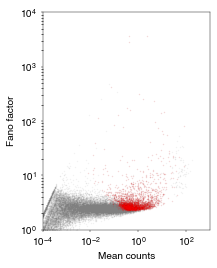

In [24]:
# check scatter
s = 2
plt.figure(figsize=(3,4))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');
#plt.savefig(project_dir, dpi = 600)

### Apply gene filter and perform PCA

In [25]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(18088, 37733)
(18088, 3000)


In [26]:
# Z score was calculated already
Z = cdata.X.copy()

In [27]:
# find the number of non-random PCs
d = srz.find_num_pc(Z[pdict["base_ix"],:],sparse=False)

calculating the first 200 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 39 	 0.25 min.
2 	 40 	 0.45 min.
3 	 40 	 0.65 min.
4 	 40 	 0.85 min.
5 	 40 	 1.05 min.
6 	 40 	 1.25 min.
7 	 40 	 1.45 min.
8 	 40 	 1.65 min.
9 	 40 	 1.87 min.
10 	 40 	 2.07 min.


In [28]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_


print(d['num_pc'])


39


In [29]:
# apply dimensionality reduction on Z (get principle components)
# note, that eigenvalues can be calculated for base_ix only
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(18088, 39)


In [30]:
#Here I store these values in adata as if scanpy pca was ran for convenience

In [31]:
cdata.obsm['X_pca'] = P
cdata.varm['PCs'] = pdict['eigenvectors'][:pdict['num_pc'],:].T
cdata.uns['pca'] = {}
cdata.uns['pca']['variance'] = pdict['eigenvalues']

## Batch correction using Harmony

In [32]:
sce.pp.harmony_integrate(cdata, 'conditions', max_iter_harmony = 15)

2023-10-01 17:47:54,756 - harmonypy - INFO - Iteration 1 of 15
2023-10-01 17:47:56,881 - harmonypy - INFO - Iteration 2 of 15
2023-10-01 17:47:58,915 - harmonypy - INFO - Iteration 3 of 15
2023-10-01 17:48:01,024 - harmonypy - INFO - Iteration 4 of 15
2023-10-01 17:48:03,169 - harmonypy - INFO - Iteration 5 of 15
2023-10-01 17:48:05,264 - harmonypy - INFO - Iteration 6 of 15
2023-10-01 17:48:07,324 - harmonypy - INFO - Iteration 7 of 15
2023-10-01 17:48:09,388 - harmonypy - INFO - Iteration 8 of 15
2023-10-01 17:48:11,443 - harmonypy - INFO - Iteration 9 of 15
2023-10-01 17:48:13,498 - harmonypy - INFO - Iteration 10 of 15
2023-10-01 17:48:15,929 - harmonypy - INFO - Converged after 10 iterations


In [35]:
#just checking if the batch correction worked properly, will adjust neighbor number or umap parameters later
sc.pp.neighbors(cdata, 15, use_rep = 'X_pca_harmony')
sc.tl.umap(cdata, min_dist = 0.7, random_state = 69)

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


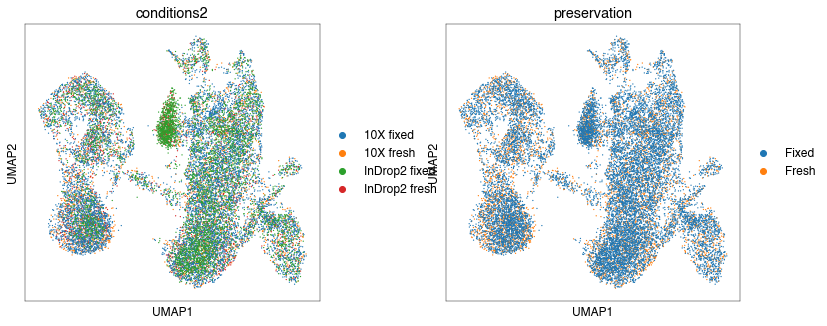

In [36]:
mpl.rcParams['figure.figsize'] = (5,5)
plt.rcParams.update({'font.size': 12})
sc.pl.umap(cdata, color = ['conditions2', 'preservation'], ncols = 2, wspace = 0.3, save = False)

## Choose the "optimal" UMAP parameters

Here I iterate over combinations of neighbor number for graph construction (n_neighbors) and min_dist parameter for visualization in UMAP in order to appreciate the differences in embedding upon parameter change and to select the approximate subjectively "best" structure preserving representation. 

In [41]:
neighbor_list = [ 10, 15, 20, 25]
dist_list = [ 0.1, 0.2, 0.3, 0.5]


10 neighbors


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


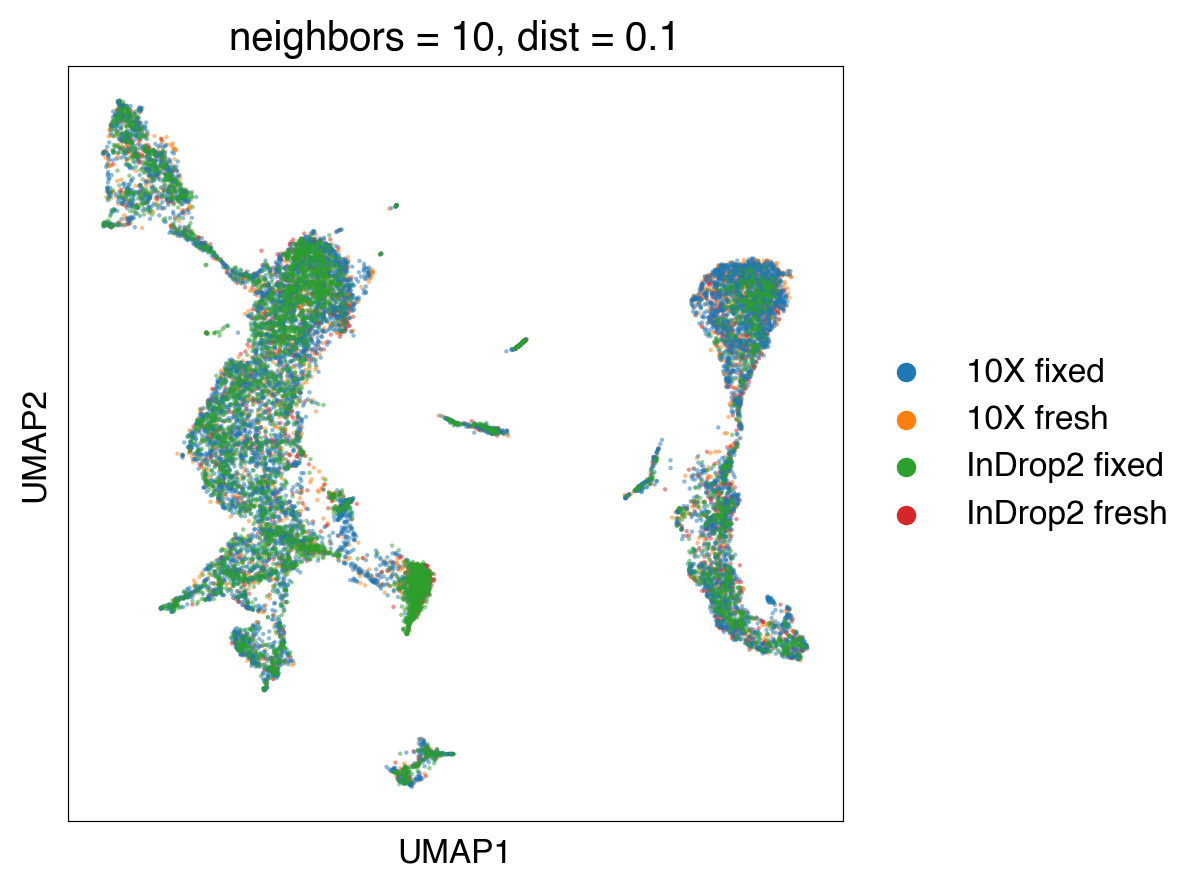

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


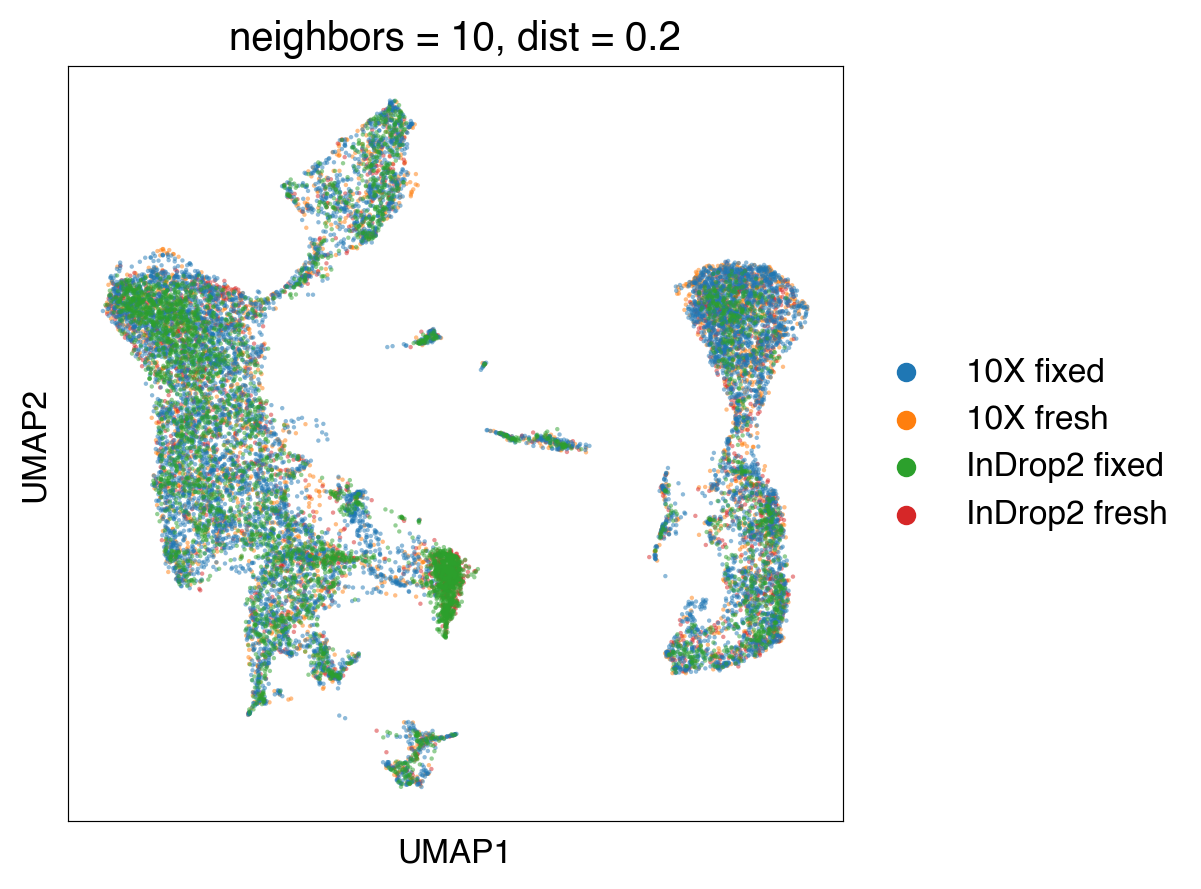

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


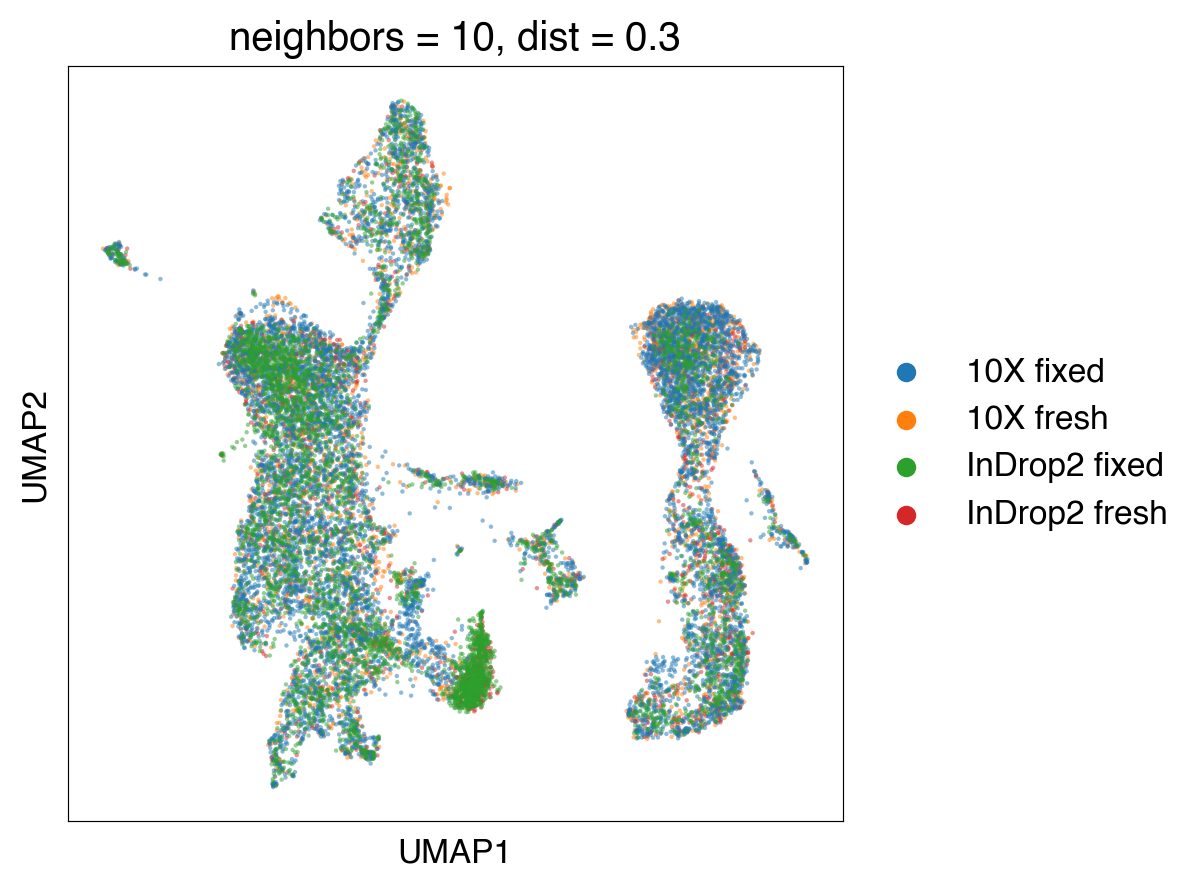

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


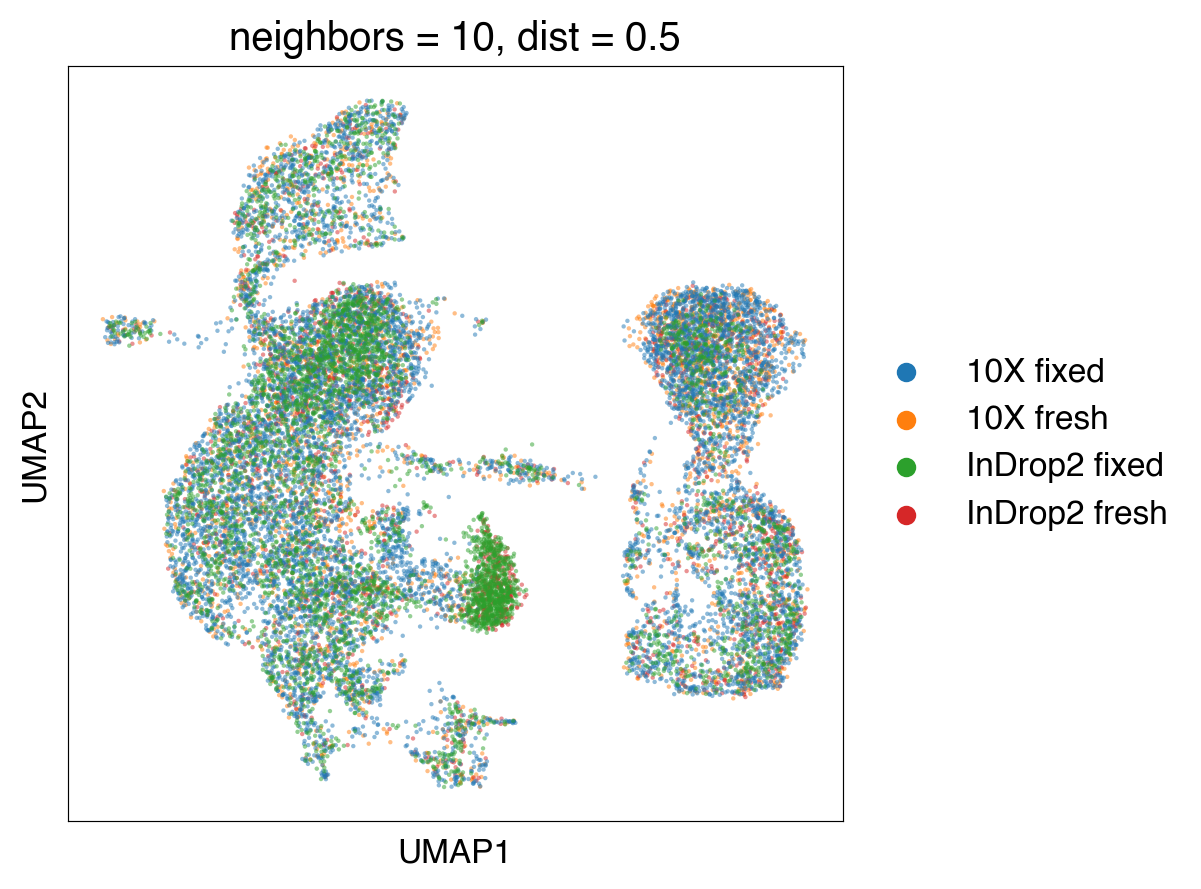

15 neighbors


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


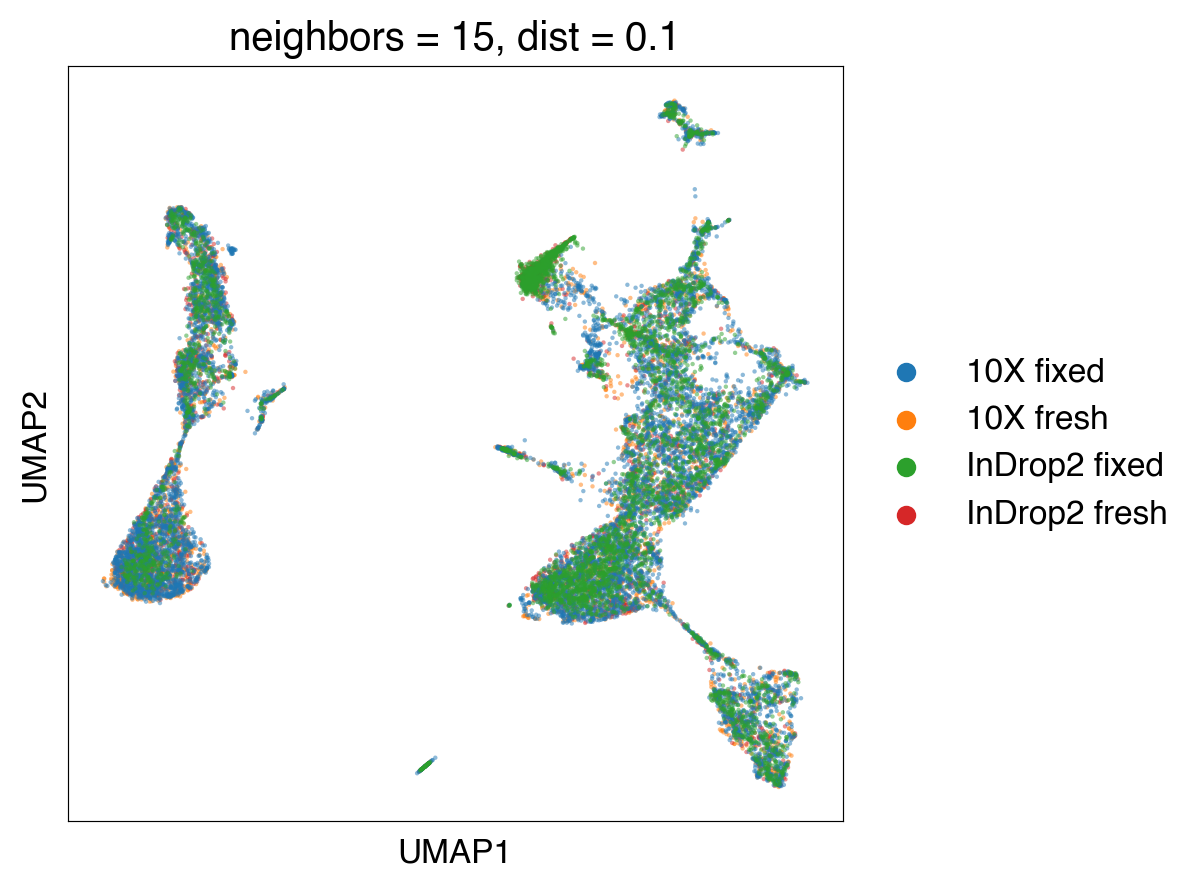

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


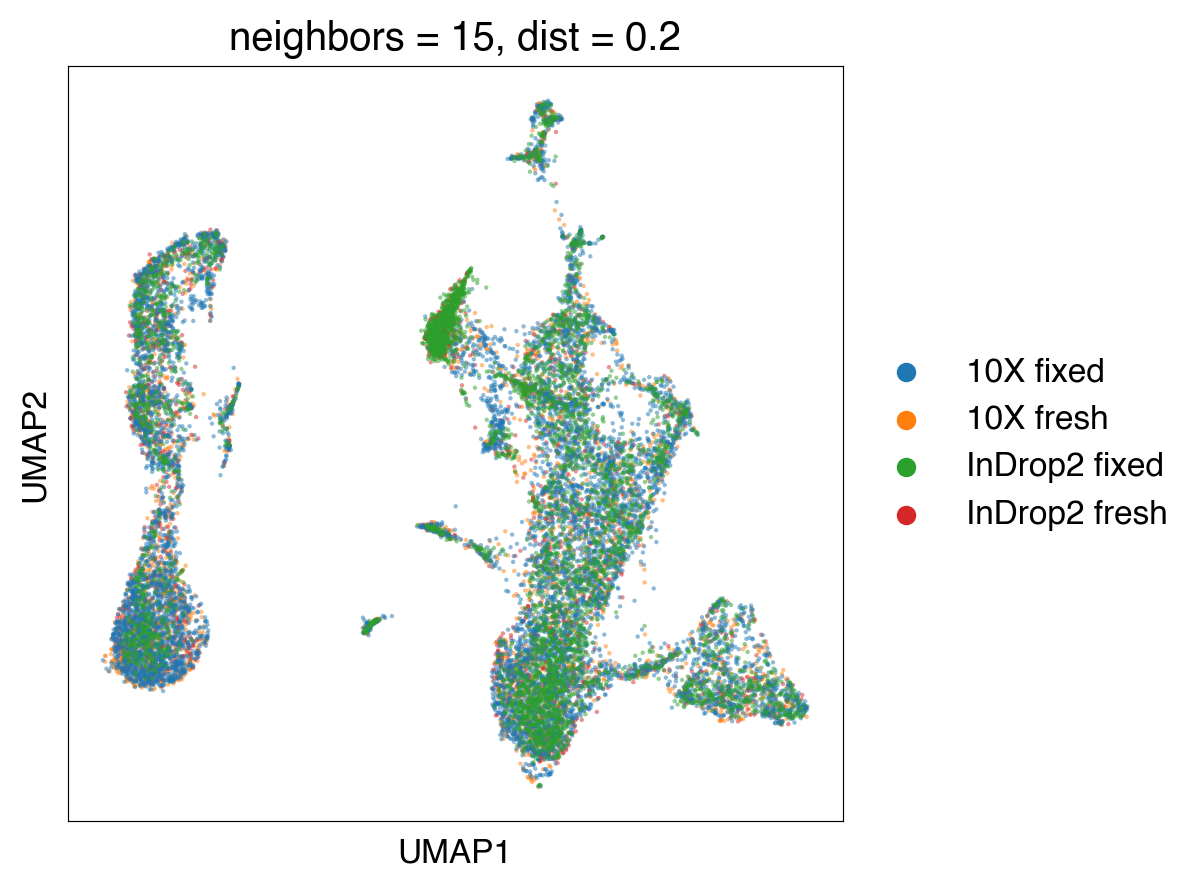

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


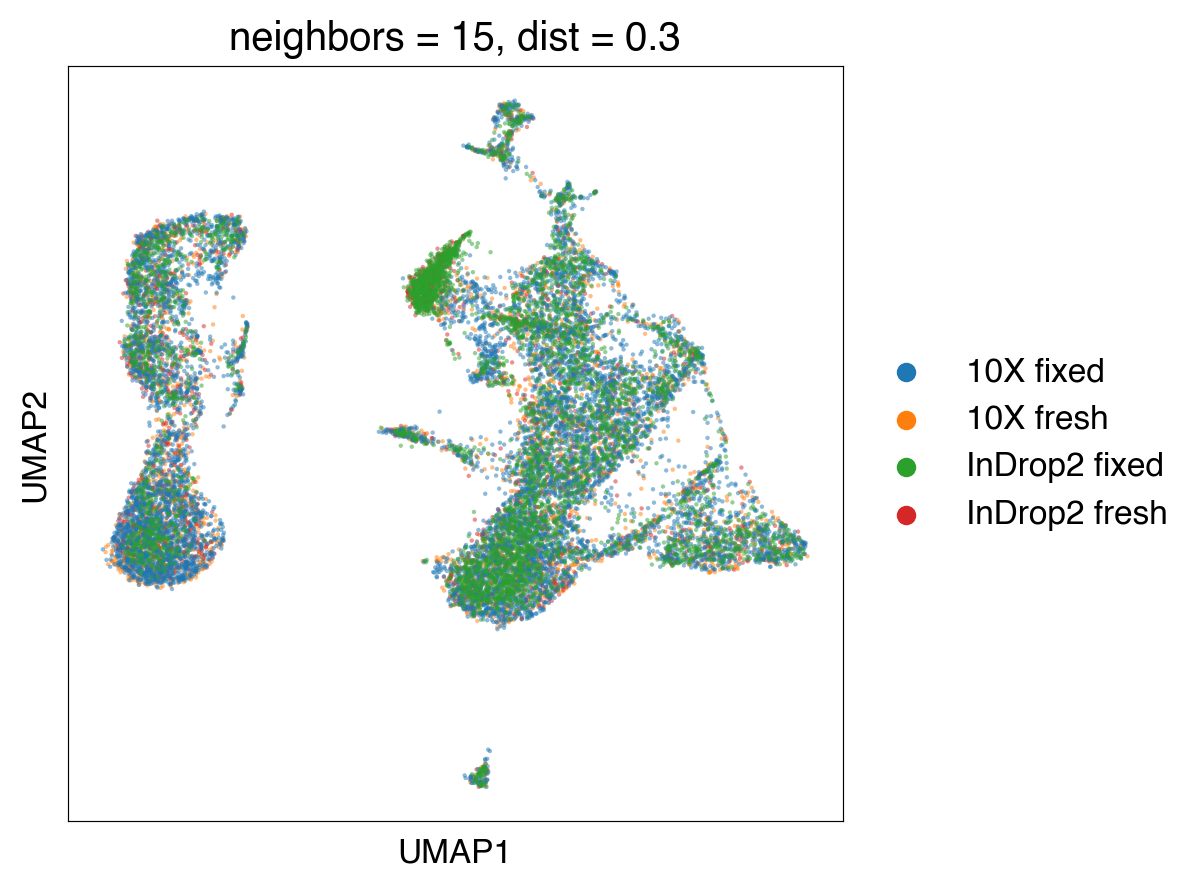

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


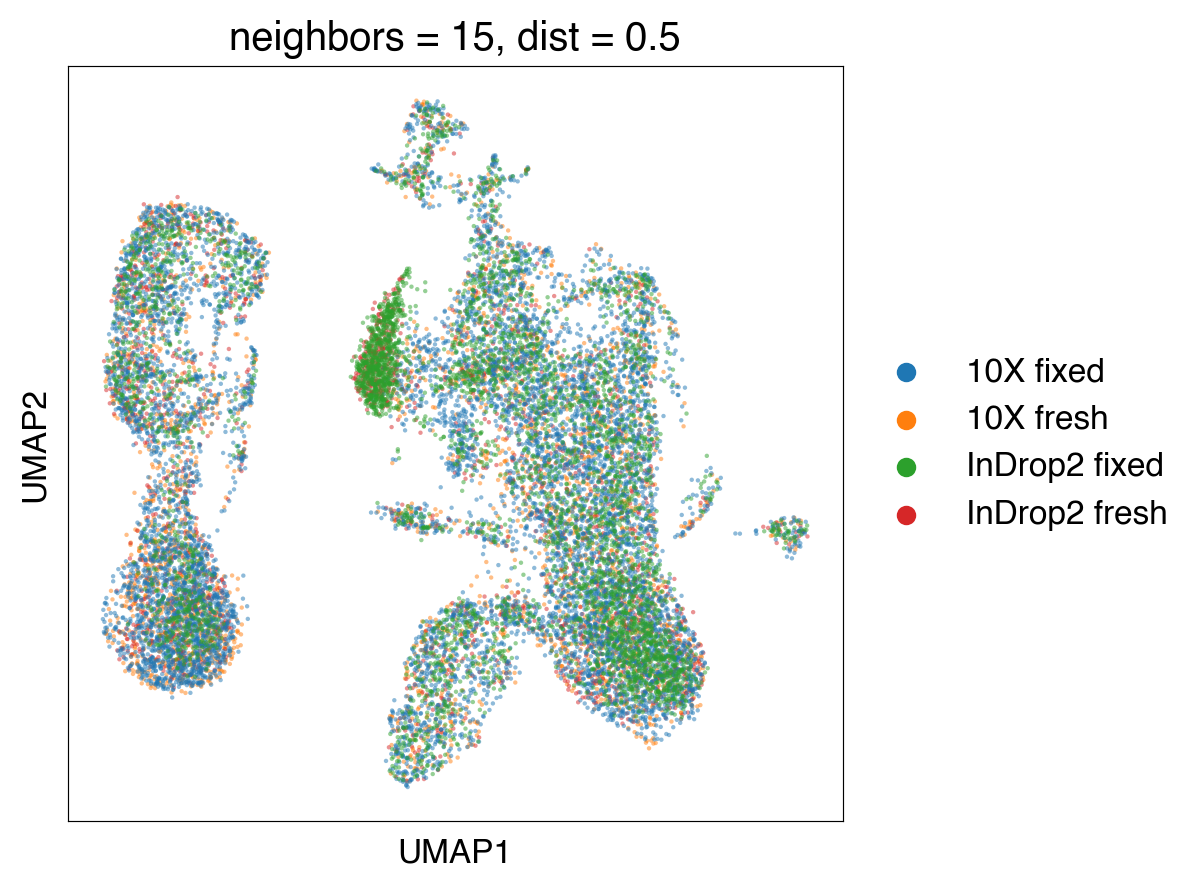

20 neighbors


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


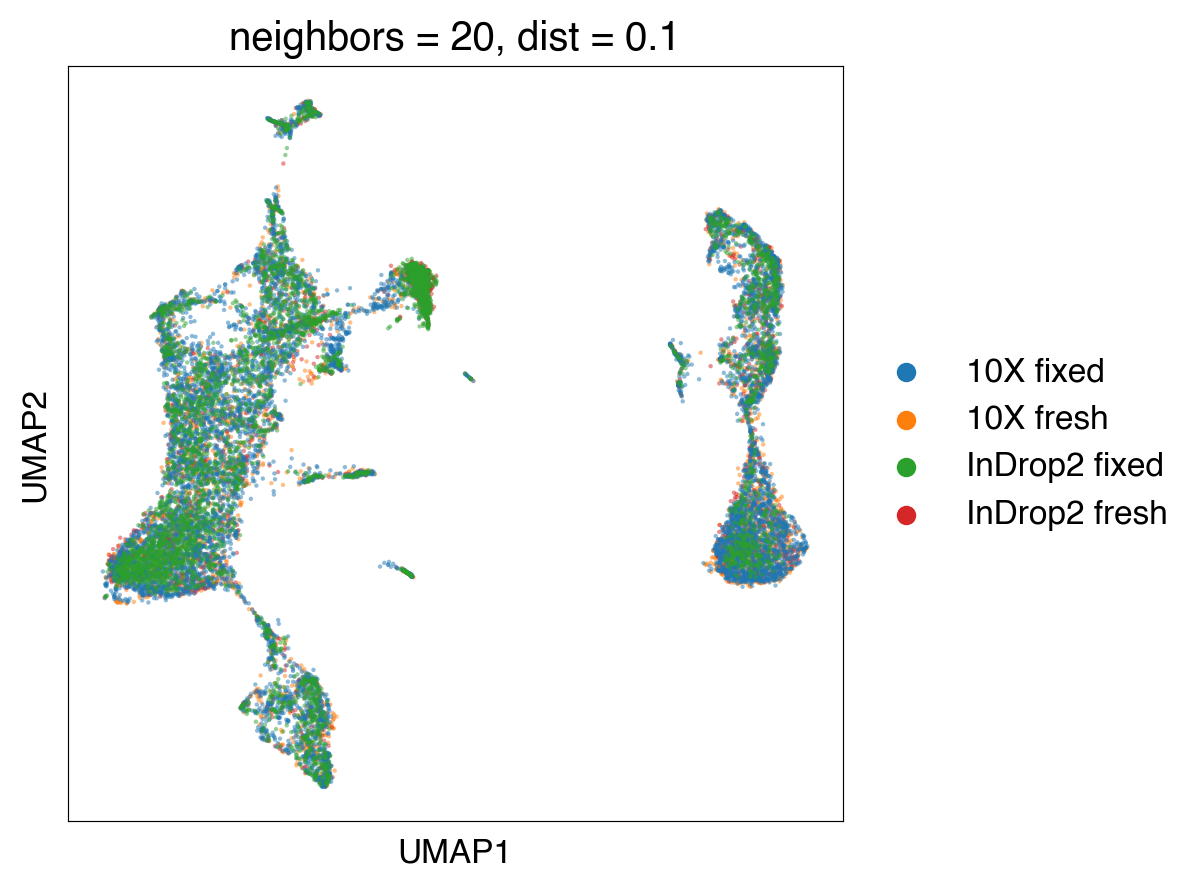

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


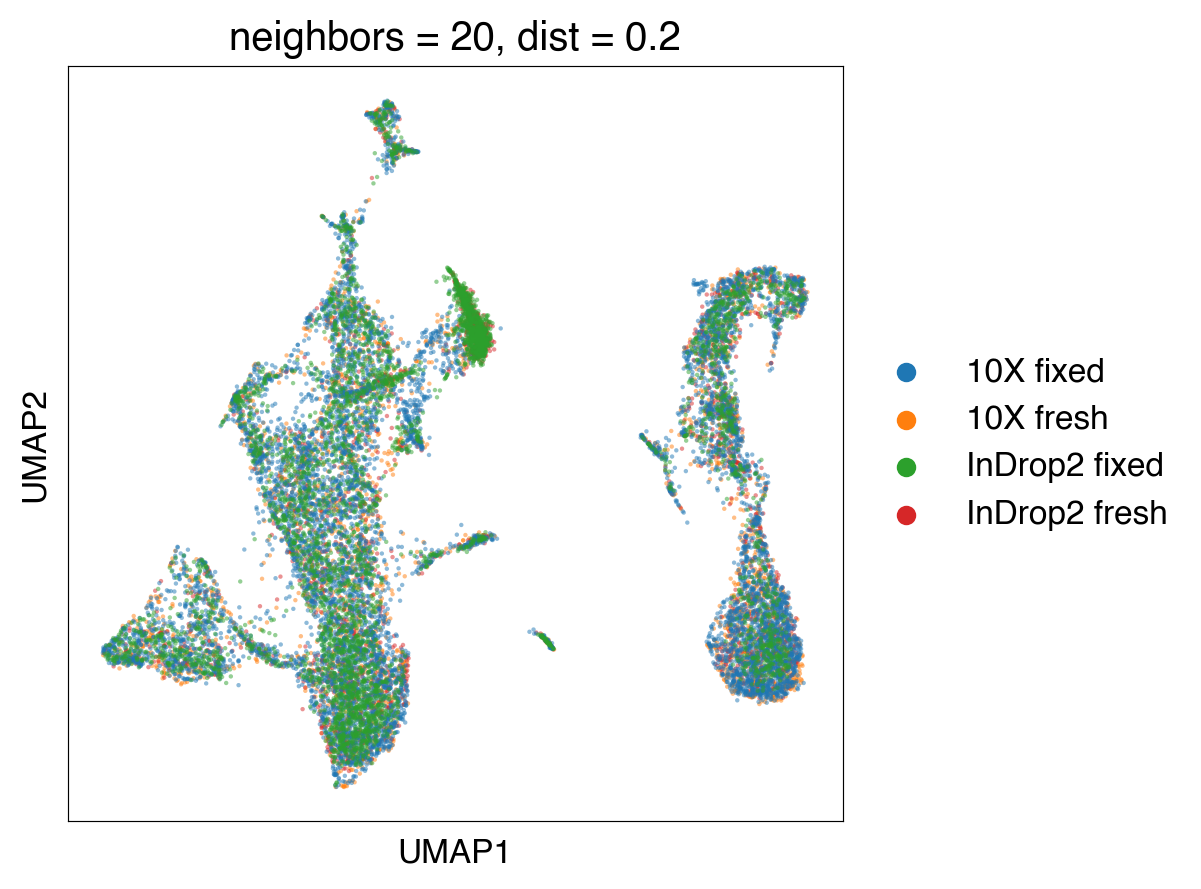

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


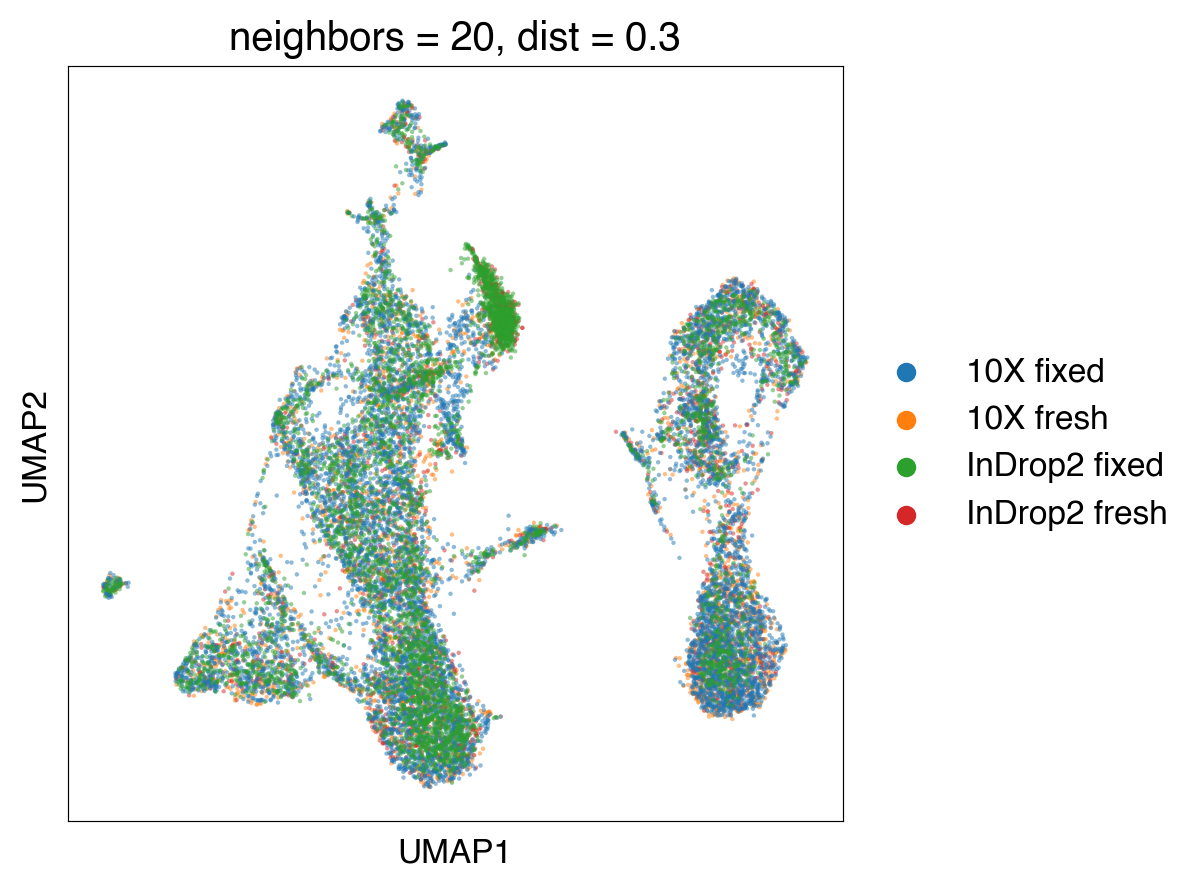

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


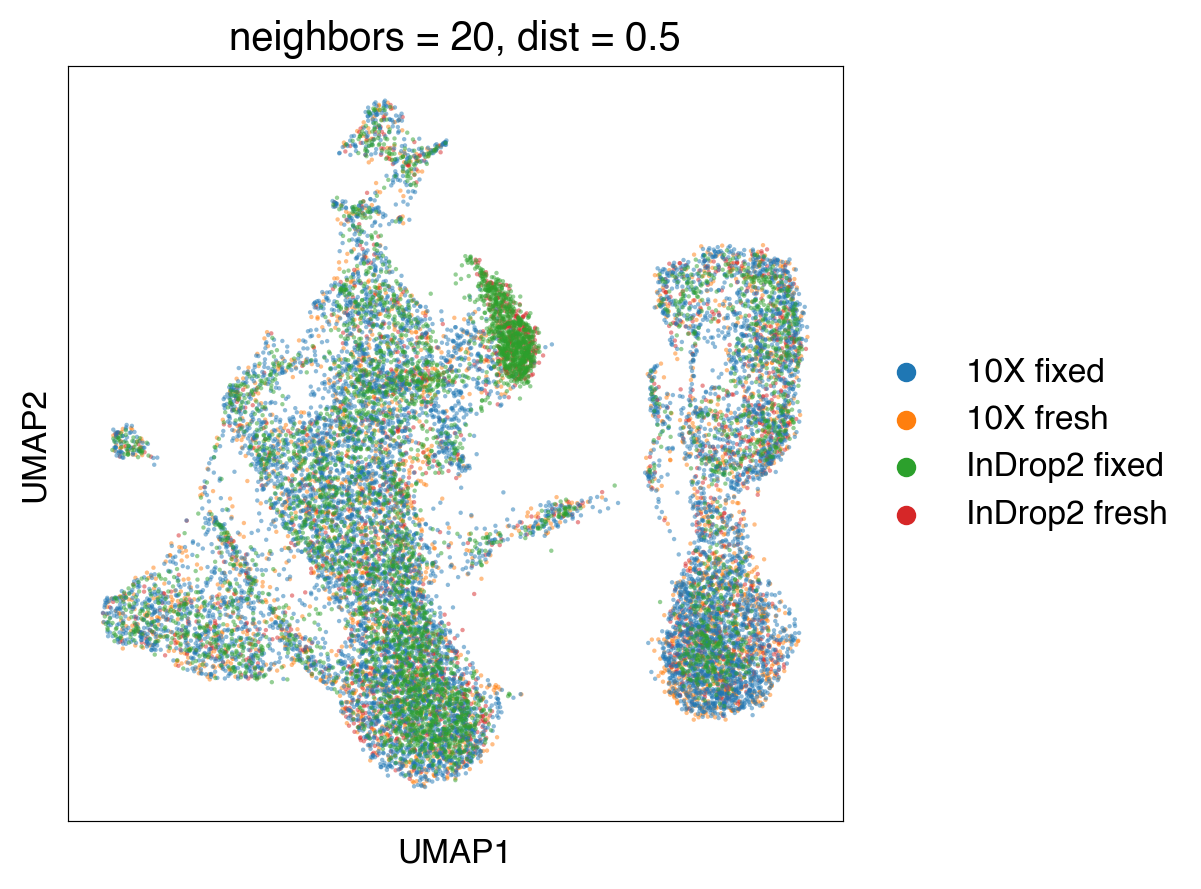

25 neighbors


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


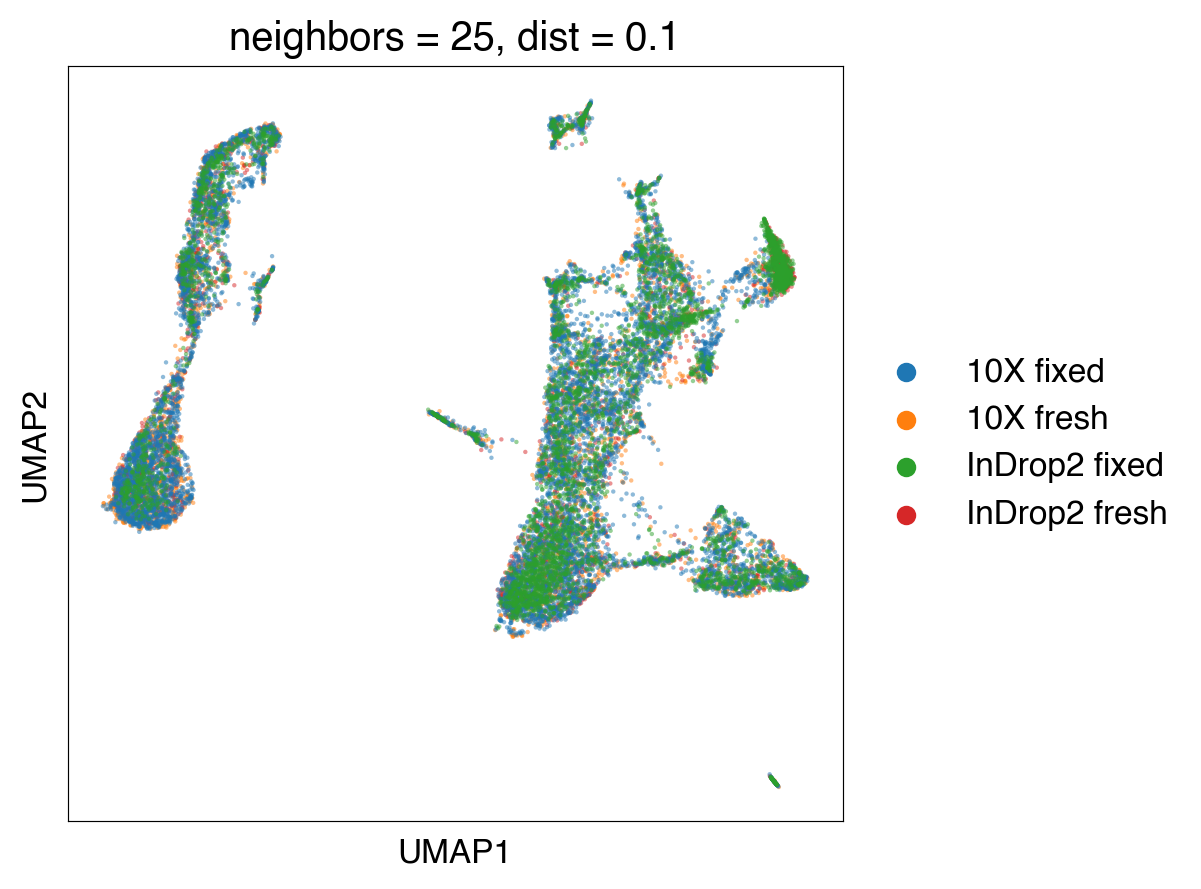

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


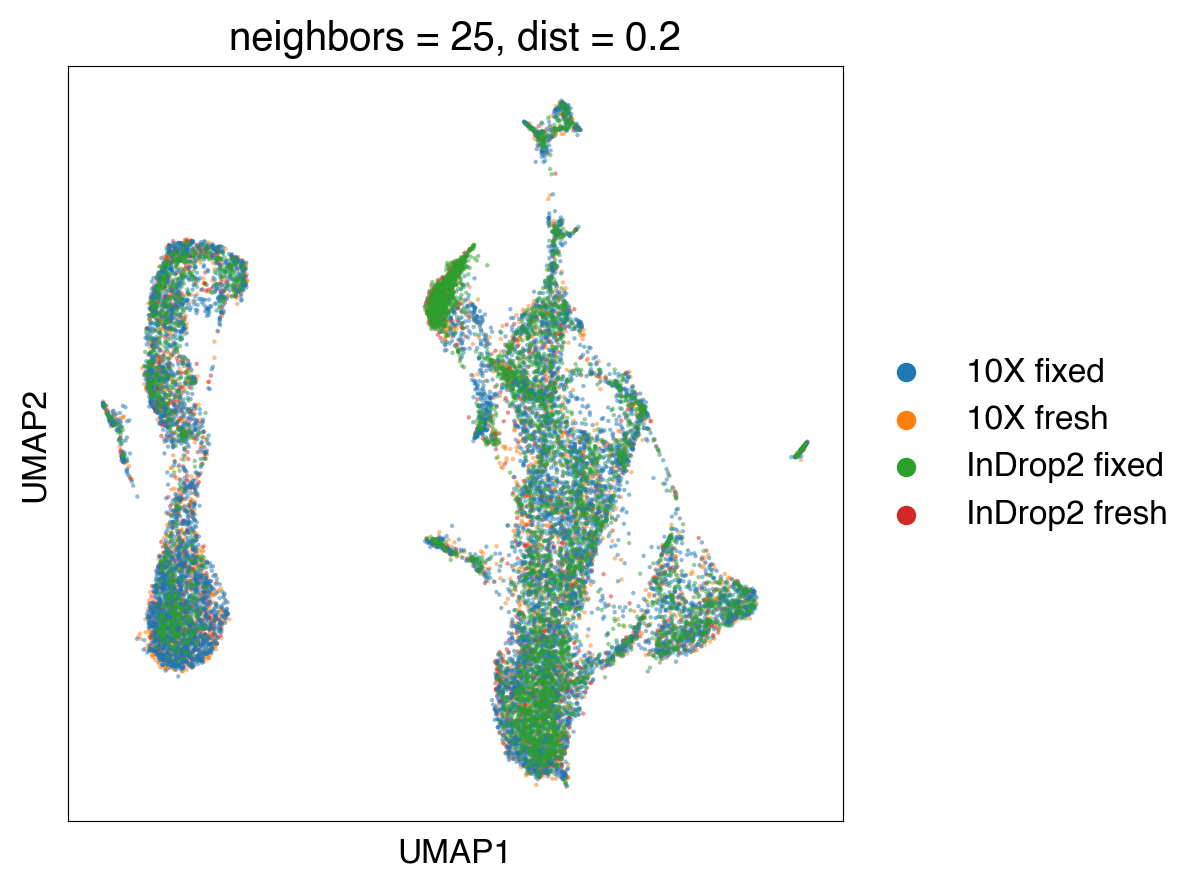

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


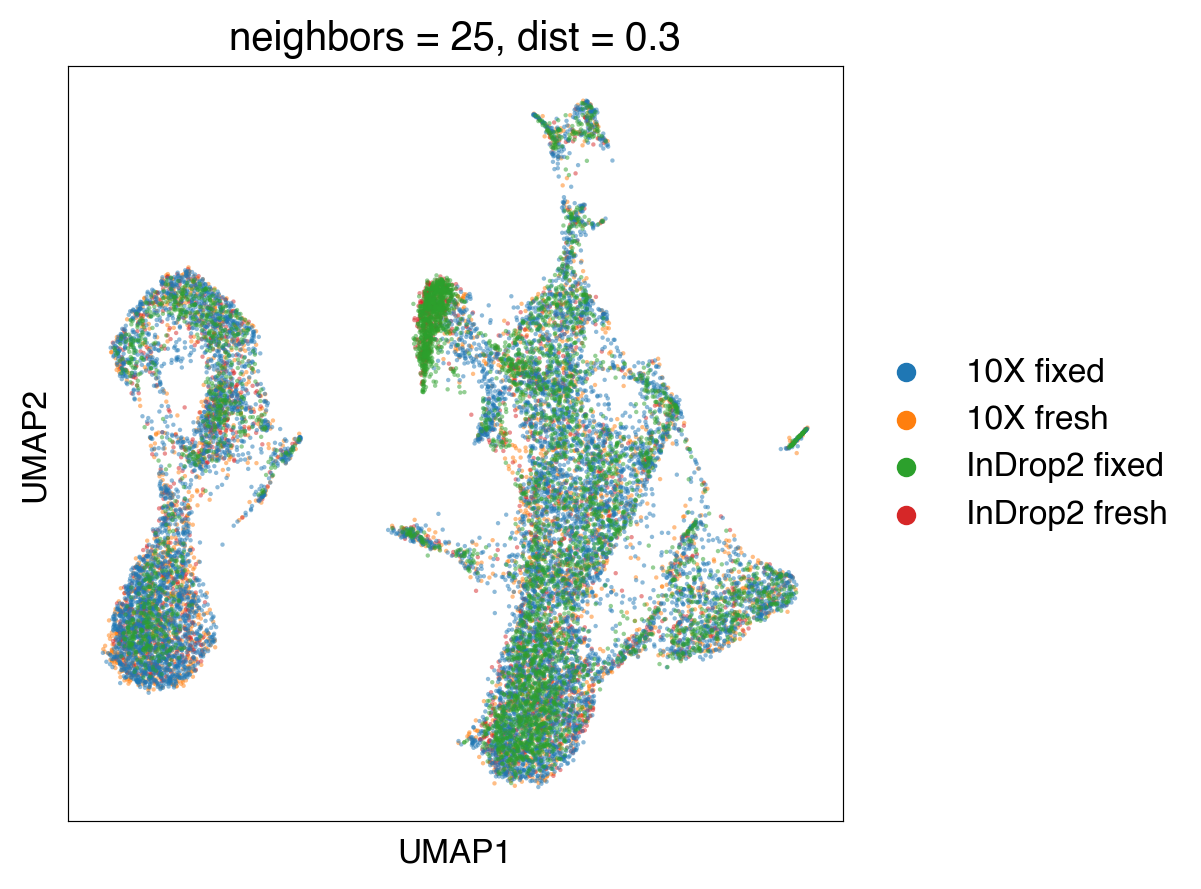

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


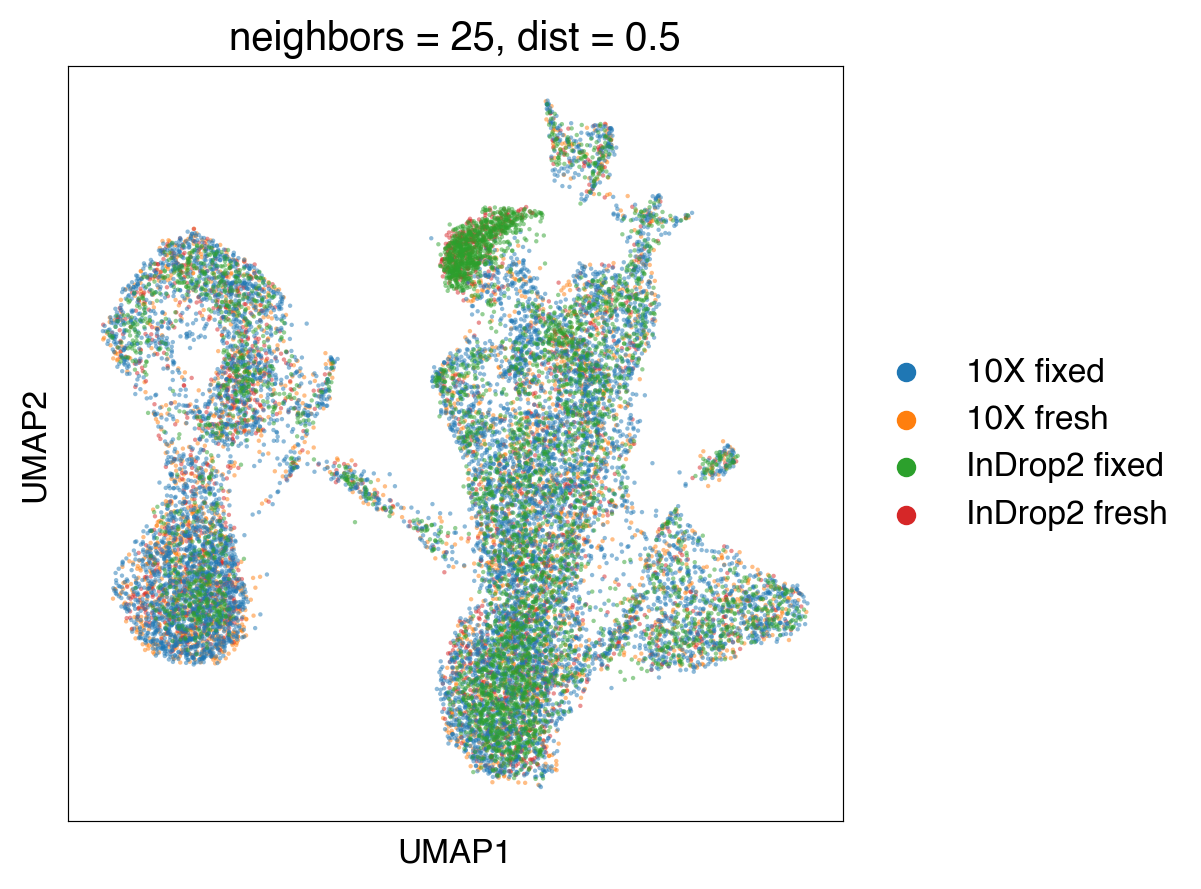

In [43]:
for j in neighbor_list:
    k = j
    print(k, 'neighbors')
    sc.pp.neighbors(cdata,k, use_rep = 'X_pca_harmony')
    for i in dist_list:
        sc.tl.umap(cdata, min_dist = i, random_state = 42)
        mpl.rcParams['figure.dpi']= 200
        mpl.rcParams['figure.figsize'] = (5,5)
        sc.pl.umap(cdata, color = 'conditions2', use_raw = False,
                   alpha = 0.5, s=10, title = 'neighbors = %s, dist = %s'% (j,i),
                   save ='%s_conditions_corrected_wo_dblt1, neighbors = %s, dist = %s.png'% (plot_name, j,i))
        

## Run UMAP with the chosen parameters

Upon inspection of the different variants of the UMAP representation selecting one that seems not too spread out and not too clumped as the first version of representation that will be used to inspect interactively in the SPRING application and for further cleanup of the dataset (Weinberg et al., 2018)

In [44]:
sc.pp.neighbors(cdata, 25 ,use_rep='X_pca_harmony')
sc.tl.umap(cdata, min_dist = 0.3, random_state = 69)


In [45]:
sc.tl.draw_graph(cdata, layout='fa') #this layout seems to work better for visual doublet detection

/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


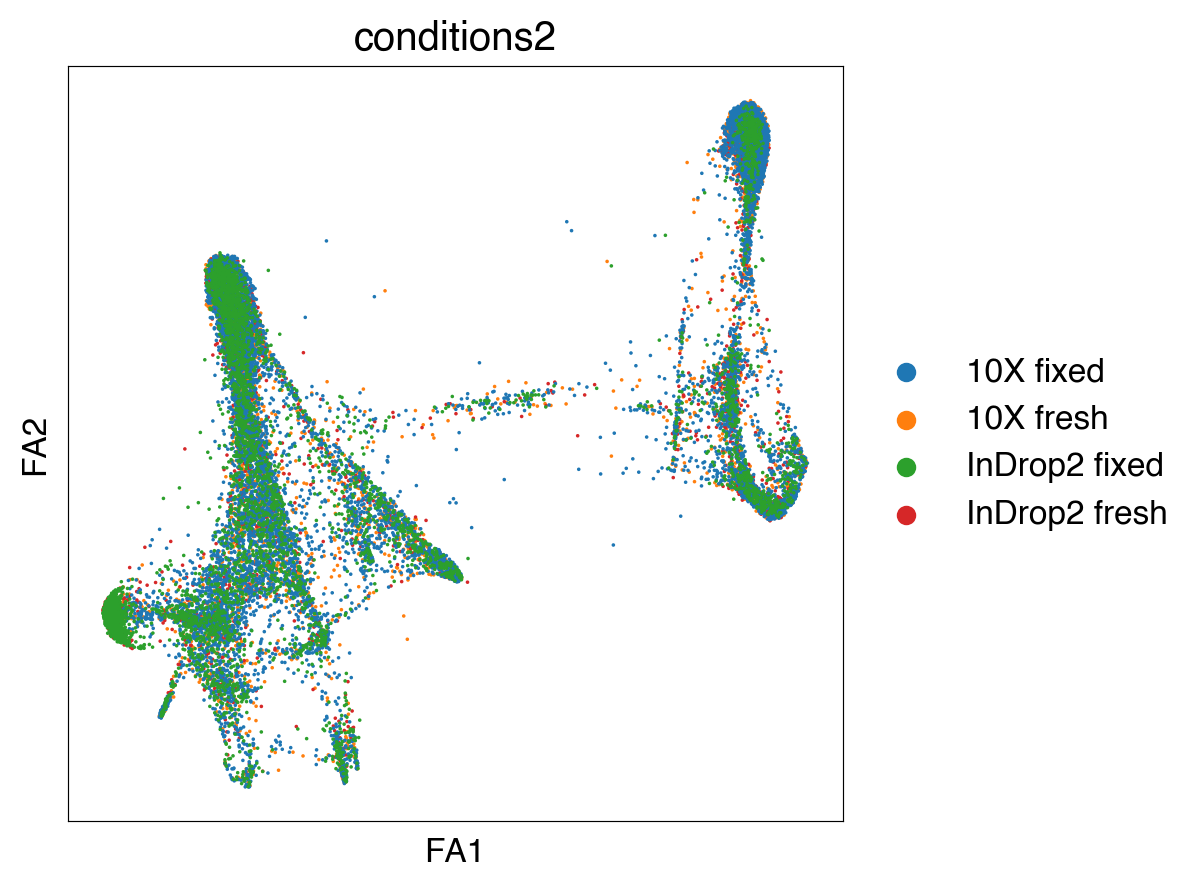

In [47]:
sc.pl.draw_graph(cdata, color = ['conditions2'])

In [48]:
#record the parameters
pdict['neighbors'] = 25
pdict['min_dist'] = 0.3

In [49]:
cdata.obs.keys()

Index(['barcode', 'library', 'total_counts', 'pct_counts_mito', 'conditions',
       'conditions2', 'preservation', 'method', 'doublet_score',
       'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score',
       'top10pct_dbtl_score', 'sp_cl_all_cells_w_dblts_spring_500',
       'removed_as_dblt1', 'n_counts'],
      dtype='object')

## Save UMAP and FDL coordinates for SPRING interactive viewer

In [52]:
# continuous per-cell metadata
contvars = ['total_counts','pct_counts_mito', 'n_counts', 'doublet_score']

# categorical
catvars = ['library', 'preservation', 'potential_doublet',
       'top3pct_dbtl_score', 'top5pct_dbtl_score', 'top10pct_dbtl_score',
        'sp_cl_all_cells_w_dblts_spring_500',
       'removed_as_dblt1','conditions',
       'conditions2'
        ]


In [53]:
# export_spring_plot was complaining about the data format, force the right one
for contvar in contvars:
    cdata.obs[contvar] = cdata.obs[contvar].astype(float).values
    
for catvar in catvars:
    cdata.obs[catvar] = cdata.obs[catvar].astype('category').values

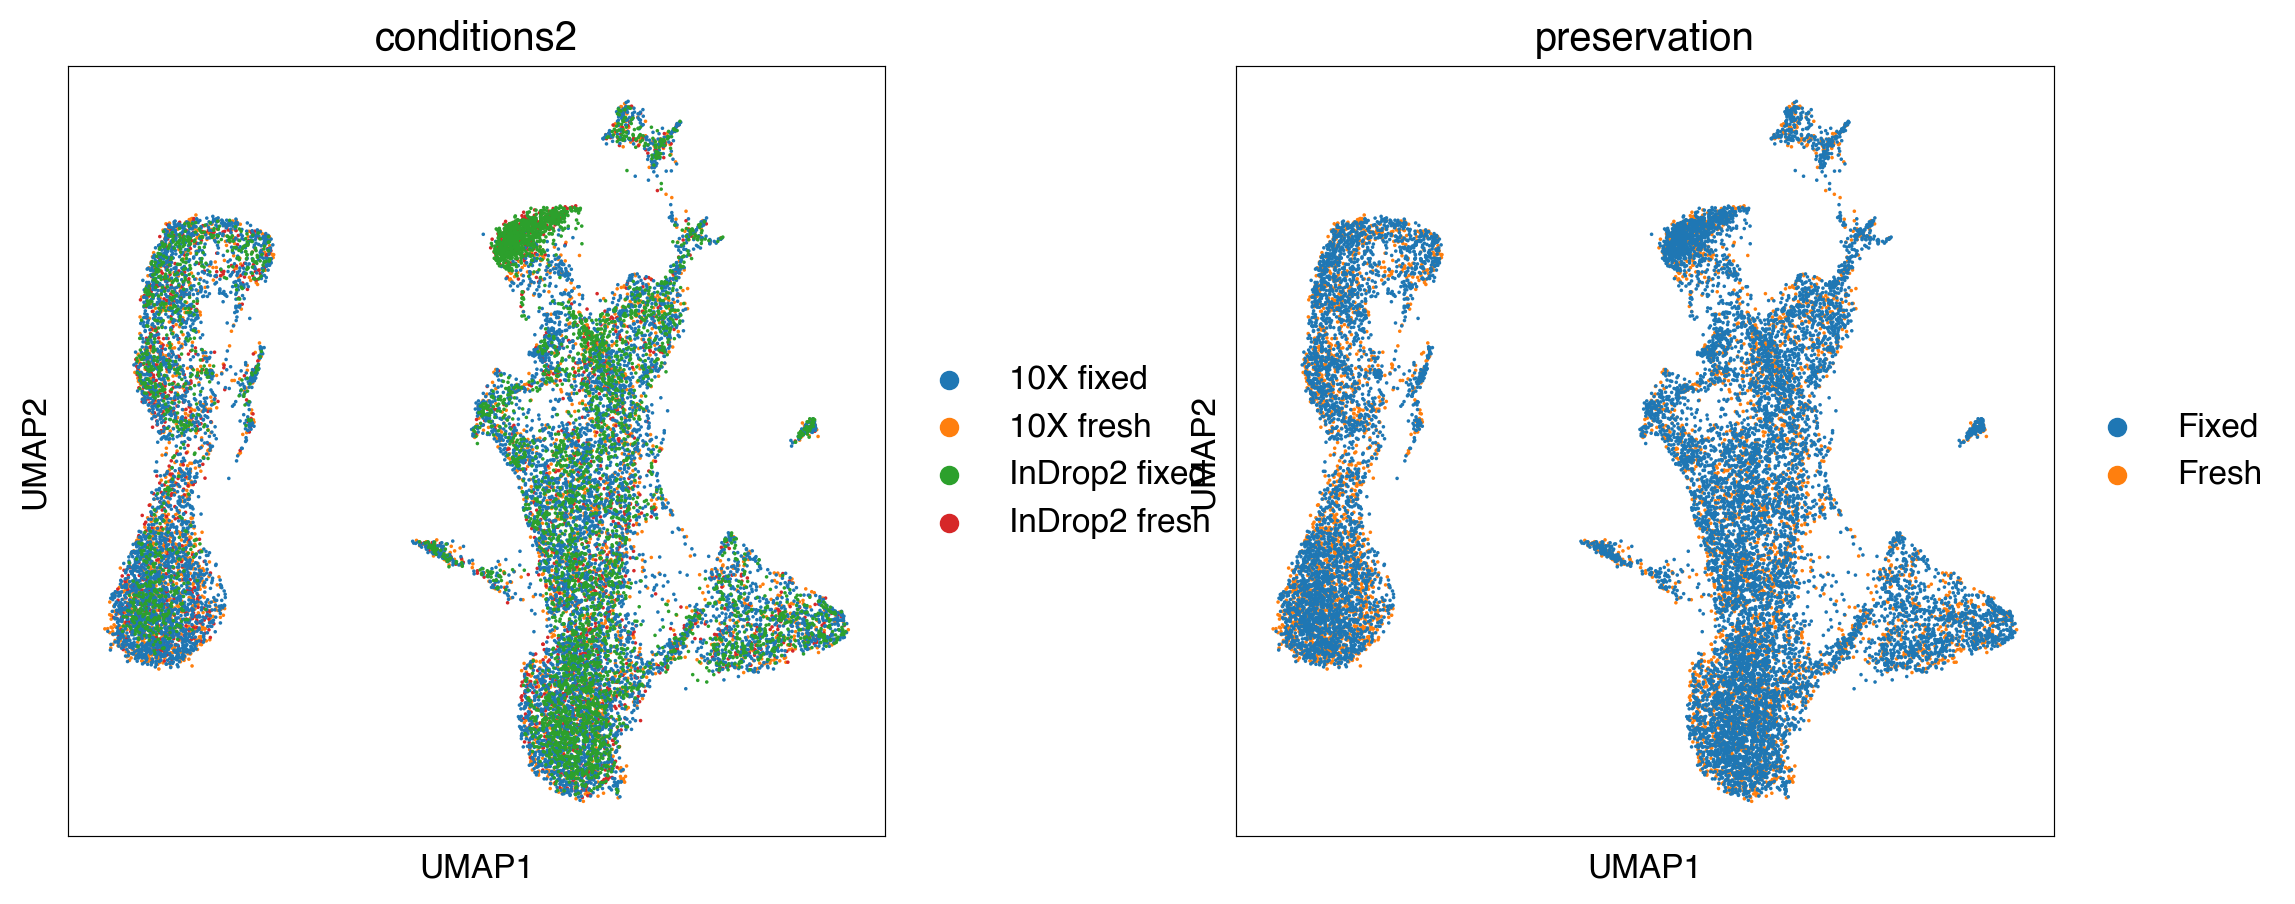

In [54]:
sc.pl.umap(cdata, color = ['conditions2', 'preservation'], ncols = 2, wspace = 0.3, save = False)

In [56]:
#cdata.X = scipy.sparse.csr_matrix(cdata.X)
sce.exporting.spring_project(cdata, project_dir = project_dir, 
                             embedding_method = 'umap', subplot_name = plot_name, cell_groupings = catvars,
                            custom_color_tracks = contvars)

Writing subplot to /Users/karolisgoda/Library/CloudStorage/GoogleDrive-karolisgoda@gmail.com/My Drive/MF/data/SPRING_dev-master/data/CD34/all_cells_wo_dblt1


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/external/exporting.py:159: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(adata.obs[obs_name]):
/opt/anaconda3/envs/sc/lib/python3.8/site-packages/scanpy/external/exporting.py:175: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif not is_categorical(adata.obs[obs_name]):


In [57]:
sce.exporting.spring_project(cdata, project_dir = project_dir, 
                             embedding_method = 'X_draw_graph_fa', subplot_name = plot_name + '_spring', cell_groupings = catvars,
                            custom_color_tracks = contvars)

Writing subplot to /Users/karolisgoda/Library/CloudStorage/GoogleDrive-karolisgoda@gmail.com/My Drive/MF/data/SPRING_dev-master/data/CD34/all_cells_wo_dblt1_spring


## Corrections to export properly

For some reason the plot in SPRING application is a mirror image of a plot I get plotting X_umap coordinates. Adjusting the coordinates to be portrayed properly in SPRING app. 

In [58]:
#for some reason the plot is a mirror image of X_umap coordinates, so let's make them look the same in SPRING app
embedding = cdata.obsm['X_umap']
coords = embedding - embedding.min(0)[None,:]
coords = coords * (np.array([1000, 1000]) / coords.ptp(0))[None,:] + np.array([200,-200])[None,:]
coords[:,1] = coords[:,1]*(-1)

In [59]:
#subplot path
subplot_path = project_dir + '/' + plot_name
subplot_path

'/Users/karolisgoda/Library/CloudStorage/GoogleDrive-karolisgoda@gmail.com/My Drive/MF/data/SPRING_dev-master/data/CD34/all_cells_wo_dblt1'

In [60]:
#saving the new coordinates to subplot folder
np.savetxt('%s/coordinates.txt'%(subplot_path),
               np.hstack((np.arange(len(embedding))[:,None], coords)),
               fmt='%i,%.6f,%.6f')

Checking in SPRING if the plot looks the same as X_umap plot: it does now

In [61]:
#save plot parameters
rz.save_stuff(path=project_dir+'/'+plot_name+'/params',stuff=pdict)


In [62]:
#save the cdata
fname = 'backups/%s_batch_corrected_w0_dblt1_%dx%d_%s.h5ad'%(plot_name, cdata.shape[0],cdata.shape[1],rz.now())
fname                                                       

'backups/all_cells_wo_dblt1_batch_corrected_w0_dblt1_18088x3000_231001_18h11.h5ad'

In [63]:
cdata.uns.pop('spring_params') #for some reason adata.write does not allow dict of dicts
#cdata.uns

{'all_cells_wo_dblt1': {'k': 10,
  'cell_mask': 160         False
  1239         True
  4688         True
  5713         True
  7475         True
              ...  
  14031962     True
  14031983     True
  14032029     True
  14032043     True
  14032062     True
  Name: removed_as_dblt1, Length: 20021, dtype: bool,
  'min_counts': 10,
  'min_cells': 5,
  'base_ix': array([    0,     1,     2, ..., 18085, 18086, 18087]),
  'num_pc': 39,
  'plot_name': 'all_cells_wo_dblt1',
  'embedding': 'umap',
  'gene_names_excluded': ['MT-ND1',
   'MT-ND2',
   'MT-CO1',
   'MT-CO2',
   'MT-ATP8',
   'MT-ATP6',
   'MT-CO3',
   'MT-ND3',
   'MT-ND4L',
   'MT-ND4',
   'MT-ND5',
   'MT-ND6',
   'MT-CYB',
   'RPS6KA1',
   'RPS8',
   'RPS27',
   'RPS6KC1',
   'RPS7',
   'RPS27A',
   'RPSA',
   'RPS3A',
   'RPS23',
   'RPS14',
   'RPS18',
   'RPS10-NUDT3',
   'RPS10',
   'RPS12',
   'RPS6KA2',
   'RPS6KA2-IT1',
   'RPS6KA2-AS1',
   'RPS20',
   'RPS6',
   'RPS24',
   'RPS13',
   'RPS6KA4',
   'RPS6KB2',
 

In [64]:
cdata.write(fname)

In [ ]:
cdata.obs

In [66]:
#no need to save obs as only 'n_counts' appeared 

In [67]:
#okay, apparently exporting spring plot did not work correctly and did not save the cell filter
cell_ix = np.arange(len(pdict['cell_mask']))[pdict['cell_mask']]


In [68]:
len(pdict['cell_mask'])

20021

In [69]:
sum(pdict['cell_mask'])

18088

In [70]:
np.savetxt(subplot_path + '/cell_filter.txt', cell_ix, fmt='%i')
np.save(subplot_path + '/cell_filter.npy', cell_ix)

In [71]:
#also noticed the colorbar saturation levels are not right because my adata raw is not normalized, however
#I want to keep it that way so overwriting manually

In [72]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

In [73]:
adata.X.sum(axis=1)

matrix([[10000.   ],
        [10000.   ],
        [ 9999.999],
        ...,
        [10000.   ],
        [ 9999.999],
        [10000.001]], dtype=float32)

In [74]:
E = adata.X[:,:].tocsc() #normalized

In [75]:
from scanpy.external.exporting import (_write_color_tracks,
                                 _get_color_stats_genes,
                                 _get_color_stats_custom,
                                 _write_color_stats
                                 )

In [76]:
gene_list = adata.var_names.values

In [77]:
# Create and write a dictionary of color profiles to be used by the visualizer
color_stats = {}
color_stats = _get_color_stats_genes(color_stats, E[cell_ix,:], gene_list)
_write_color_stats(subplot_path + '/color_stats.json', color_stats)

In [78]:
spring_path = subplot_path + '_spring' #updating for the spring plot as well

In [79]:
_write_color_stats(spring_path + '/color_stats.json', color_stats)

In [80]:
np.savetxt(spring_path + '/cell_filter.txt', cell_ix, fmt='%i')
np.save(spring_path + '/cell_filter.npy', cell_ix)